# NASA SPACE APPS 2025: HUNTING FOR EXOPLANETS WITH AI

 ## INSTALLING AND IMPORTING NECESSARY PACKAGES:

In [19]:
## pip install numpy
## pip install pandas
## pip install scikit-learn
## pip install xgboost
## pip install matplotlib
## pip install jolib

Defaulting to user installation because normal site-packages is not writeable


In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import joblib

## ORGANIZING DATA FOR TRAINING

In [28]:
# Load the dataset
df = pd.read_csv("normalized_data.xls", comment='#')

# Separate features (X) and target variable (y)
X=df.drop(columns=['koi_disposition'])
y=df['koi_disposition']

# Initial data split (used solely for feature selection training)
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Feature Selection using SelectKBest with f_regression (ANOVA F-value) to select the top 20 features
selector = SelectKBest(score_func=f_regression,k=20)
selector.fit(X_train,y_train)

# Get the names of the selected features
selected_features=X_train.columns[selector.get_support()]
# Exclude the 'koi_score' feature from the selected list
selected_features_sem_score = [feature for feature in selected_features if feature != 'koi_score']

### FENWICK TREE (BINARY INDEXED TREE) ARCHITECTURE

In [29]:
# Define the list of continuous columns to be used for Fenwick Tree and Autoencoder
continuous_cols = selected_features_sem_score


# Fenwick Tree Class (Required) - Binary Indexed Tree for prefix sums

class FenwickTree:
    # Constructor: initializes the tree array with size N+1
    def __init__(self, size):
        self.n = size + 1
        self.tree = [0] * self.n
    # Updates the value at index 'i' by 'delta'
    def update(self, i, delta):
        i += 1 # 1-based indexing
        while i < self.n:
            self.tree[i] += delta
            i += i & -i # Move to the next relevant index (least significant bit trick)
    # Queries the prefix sum up to index 'i'
    def query(self, i):
        i += 1 # 1-based indexing
        res = 0
        while i > 0:
            res += self.tree[i]
            i -= i & -i # Move to the parent index
        return res

# Data Preparation (X_train_raw/X_test_raw now with Cumulative Features)

# Final data split for modeling (RAW data used as base)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Add cumulative features using Fenwick Tree to the RAW dataframes
for col in continuous_cols:
    # Initialize separate Fenwick Trees for train and test sets
    ft_train, ft_test = FenwickTree(len(X_train_raw)), FenwickTree(len(X_test_raw))
    cum_train, cum_test = [], []
    
    # Train Data: Calculate cumulative sum
    for i, val in enumerate(X_train_raw[col].values):
        ft_train.update(i, val)
        cum_train.append(ft_train.query(i))
    # Add new cumulative feature to X_train_raw
    X_train_raw[f'{col}_cum'] = cum_train
    
    # Test Data: Calculate cumulative sum
    for i, val in enumerate(X_test_raw[col].values):
        ft_test.update(i, val)
        cum_test.append(ft_test.query(i))
    # Add new cumulative feature to X_test_raw
    X_test_raw[f'{col}_cum'] = cum_test


## TRAINING!

### FIRST MODEL: CONVENTIONAL XGB  

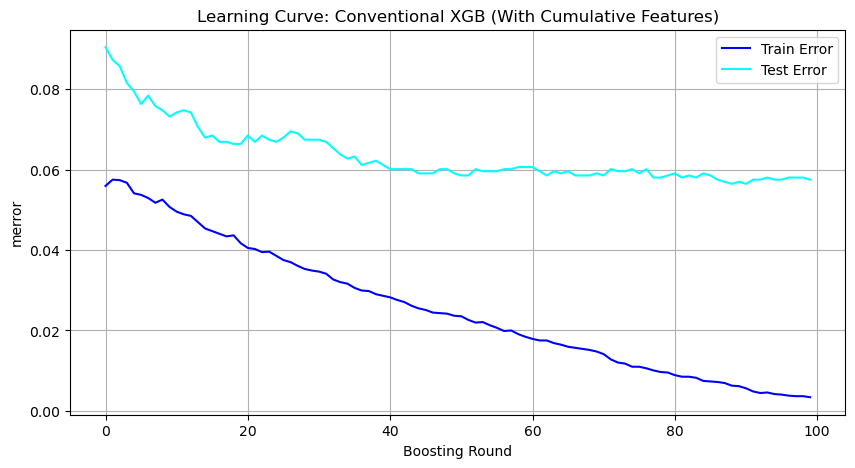

In [30]:
#  (now with cumulative features)

# Create DMatrix for XGBoost using the RAW data (now includes cumulative features)
dtrain_xgb=xgb.DMatrix(X_train_raw, label=y_train)
dtest_xgb=xgb.DMatrix(X_test_raw, label=y_test)



# XGBoost model parameters for multi-class classification
params = {
    "objective": "multi:softmax", # Multi-class classification objective
    "num_class": len(y.unique()), # Number of unique classes in target
    "tree_method": "hist", # Use faster histogram-based method
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "merror", # Evaluation metric: misclassification error rate
    "verbosity": 1
}

# Training and evaluation setup
evals_xgb = [(dtrain_xgb, 'train'), (dtest_xgb, 'test')]
evals_result_xgb = {}

# Train the XGBoost model
bst_xgb = xgb.train(params, dtrain_xgb, num_boost_round=100,
                     evals=evals_xgb, evals_result=evals_result_xgb, verbose_eval=False)

# Plot XGB conventional learning curve
plt.figure(figsize=(10,5))
plt.plot(evals_result_xgb['train']['merror'], label='Train Error', color='blue')
plt.plot(evals_result_xgb['test']['merror'], label='Test Error', color='cyan')
plt.xlabel('Boosting Round')
plt.ylabel('merror')
plt.title('Learning Curve: Conventional XGB (With Cumulative Features)')
plt.legend()
plt.grid(True)
plt.show()

### SECOND MODEL 2: XGB + AUTOENCODER (AE)

123


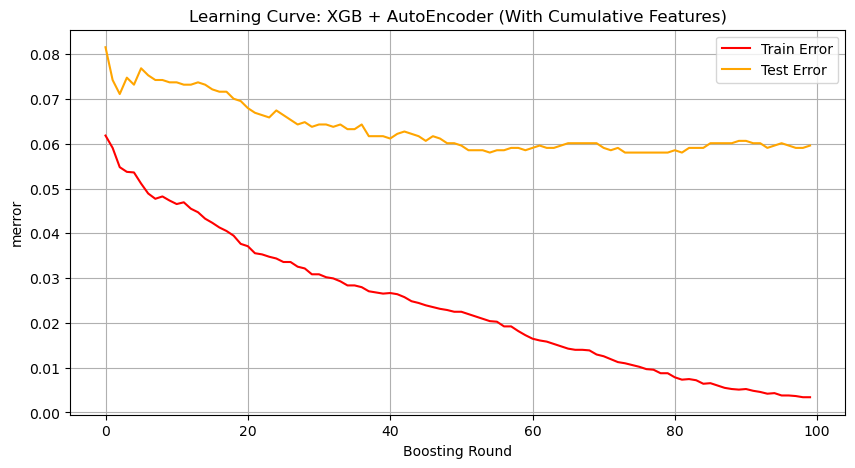

In [35]:
# Autoencoder trained only on the 'CONFIRMED' class (assuming class label 2)
X_normal = X_train_raw[y_train==2].copy()

# The AE is trained ONLY on the base continuous features (no cumulative features)
X_normal_feats = X_normal[continuous_cols]

# Initialize the Multi-Layer Perceptron Regressor (Autoencoder architecture)
mlp_ae = MLPRegressor(hidden_layer_sizes=(32,16,8,16,32),
                     activation='relu', solver='adam',
                     max_iter=500, random_state=42)

# Train the Autoencoder on the 'normal' class data
mlp_ae.fit(X_normal_feats, X_normal_feats)

# Prepare dataframes for the AE model: copy the RAW data (which includes cumulative features)
X_train_ae=X_train_raw.copy()
X_test_ae=X_test_raw.copy()

# Calculate the reconstruction error and add it as a new feature
# Error is calculated as the Mean Squared Error between original features and their reconstruction
X_train_ae['reconstruction_error']=np.mean((X_train_raw[continuous_cols] - mlp_ae.predict(X_train_raw[continuous_cols]))**2, axis=1)
X_test_ae['reconstruction_error']=np.mean((X_test_raw[continuous_cols] - mlp_ae.predict(X_test_raw[continuous_cols]))**2, axis=1)

# Get the final list of feature names including the calculated 'reconstruction_error'
feature_names = list(X_train_ae.columns)
# Save the feature list (123 features) to ensure the prediction API uses the correct order
joblib.dump(feature_names, "features_xgb.pkl")

# Create DMatrix for XGBoost Model 2 (includes cumulative features and reconstruction error)
dtrain_ae=xgb.DMatrix(X_train_ae, label=y_train)
dtest_ae=xgb.DMatrix(X_test_ae, label=y_test)

# Training and evaluation setup for Model 2
evals_ae=[(dtrain_ae, 'train'), (dtest_ae, 'test')]
evals_result_ae={}
# Train the XGBoost model with the AE feature
bst_ae=xgb.train(params, dtrain_ae, num_boost_round=100,
                     evals=evals_ae, evals_result=evals_result_ae, verbose_eval=False)

# Plot XGB + AE learning curve
plt.figure(figsize=(10,5))
plt.plot(evals_result_ae['train']['merror'], label='Train Error', color='red')
plt.plot(evals_result_ae['test']['merror'], label='Test Error', color='orange')
plt.xlabel('Boosting Round')
plt.ylabel('merror')
plt.title('Learning Curve: XGB + AutoEncoder (With Cumulative Features)')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Save the final XGBoost classifier model (which uses the reconstruction error feature)
bst_ae.save_model("xgb_model_ae.json")

In [25]:

# Save the Autoencoder (AE) model, which is necessary to calculate the 'reconstruction_error' 
# feature during the real-time prediction in the API
joblib.dump(mlp_ae, "autoencoder_model.pkl")

['autoencoder_model.pkl']